In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats
import corner

In [2]:
def burst(par, x): 
    t_0, b, A, alpha = par
    return np.where(x < t_0, b, b + A * np.exp(-alpha * (x - t_0)))

In [3]:
def logL(par, tdata, model = burst): 
    x, y, yerr = tdata.T
    return -0.5 * np.sum(np.power((y - model(par, x)) / yerr, 2))

In [4]:
def logprior(par):
    t_0, b, A, alpha = par 
    if Amin < A < Amax and bmin < b < bmax and t_0min < t_0 < t_0max and alphamin < alpha < alphamax:
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    return -np.inf

In [5]:
def logposterior(par, tdata, model = burst):
    return logL(par, tdata) + logprior(par)

In [6]:
#Get the data → The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux.
data = np.load('../solutions/transient.npy')
print(data[:10, :]) #Print the first ten terms

[[ 0.46954762  8.83485016  1.        ]
 [ 1.87898004 10.90082649  1.        ]
 [ 2.01075462 10.46566244  1.        ]
 [ 2.02183974  8.46375631  1.        ]
 [ 3.91877923 11.48825219  1.        ]
 [ 6.02254716 11.89588918  1.        ]
 [ 6.41474963 11.17877957  1.        ]
 [ 7.10360582  9.82007516  1.        ]
 [ 8.71292997  8.92924738  1.        ]
 [ 9.39405108 11.05445173  1.        ]]


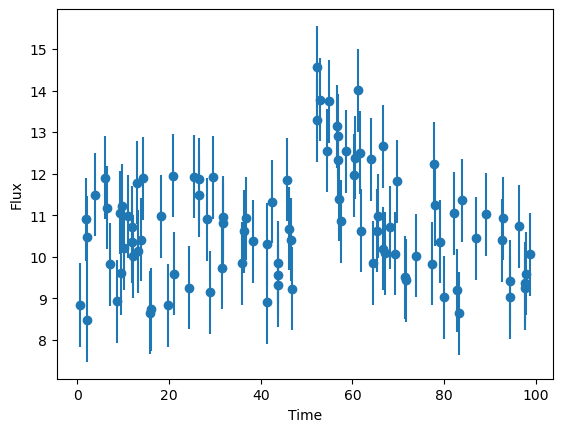

In [7]:
#Plot the data with their uncertainties
plt.errorbar(data[:, 0], data[:, 1], data[:, 2], fmt = 'o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [8]:
#Set the ranges for the priors
t_0min,t_0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

In [9]:
#Let's perform the sampling
ndim = 4 #There are four parameters in this model
nwalkers = 20 #MCMC walkers
nsteps = int(1e4) #Steps for each walker

In [10]:
t0_quick=50
A_quick=10
b_quick=10
alpha_quick=0.1


theta_quick= np.array([t0_quick,b_quick,A_quick,alpha_quick])

starting_guesses = theta_quick + 1e-1* np.random.randn(nwalkers, ndim)

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[data, burst])
sampler.run_mcmc(starting_guesses, nsteps)

/home/morgan/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


State([[50.0481566  10.64501352  4.24837075  0.12241572]
 [47.27010978 10.33738016  5.63955066  0.11811236]
 [49.2195706  10.25944908  4.53024659  0.10672566]
 [50.04448532 10.41010349  4.4558154   0.12324787]
 [46.90658401 10.12971589  9.398202    0.1498404 ]
 [50.27550486 10.33195657  4.18862011  0.11192189]
 [51.8856057  10.29338914  3.9961374   0.12473038]
 [48.28201719 10.32850823  6.50583977  0.12990312]
 [47.12428187 10.25546539  6.71142557  0.11065493]
 [47.40645555 10.24204729  8.82330277  0.15895406]
 [52.12635121 10.07674579  4.4237302   0.11649237]
 [49.05670037 10.27738135  4.60701125  0.09011654]
 [51.95040459 10.47925848  4.32460547  0.14439606]
 [48.60742035 10.46003363  6.59419575  0.1661006 ]
 [49.17068734 10.36805863  4.88135477  0.11610617]
 [47.53968424 10.41692978  6.16931479  0.14501528]
 [47.12487374 10.20817879  6.10307805  0.09433935]
 [47.90674724 10.36277427  7.62159774  0.17622416]
 [51.04456133 10.38936293  3.5878395   0.14969309]
 [51.56395686 10.19264957

Text(0.5, 0, 'step number')

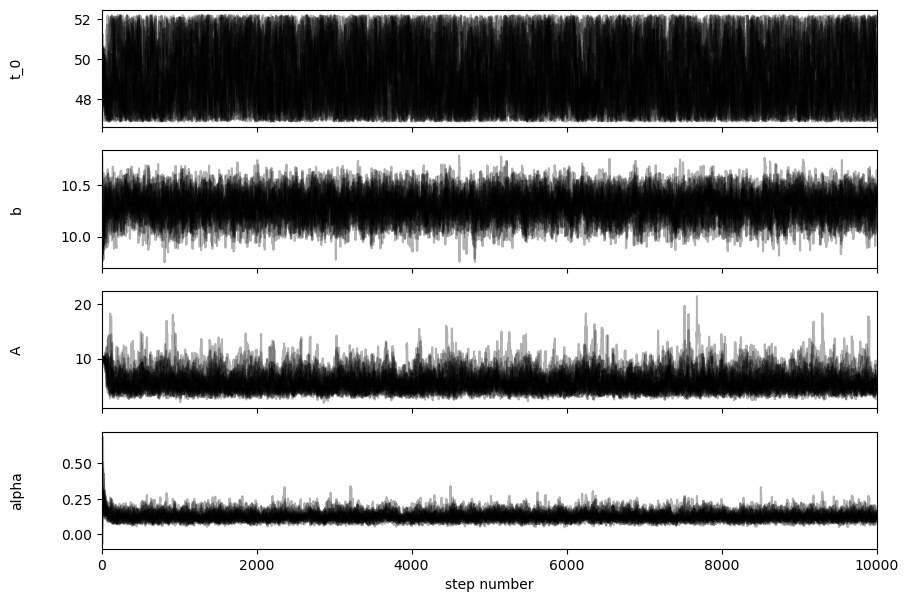

In [12]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t_0","b","A","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [13]:
#Obtain the autocorrelation lenght in each direction
tau = sampler.get_autocorr_time()
print(tau)

[71.50992803 55.64980295 68.22137482 58.4652998 ]


In [14]:
#Get rid off the burn in using the autocorrelation  lenght
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(2740, 4)


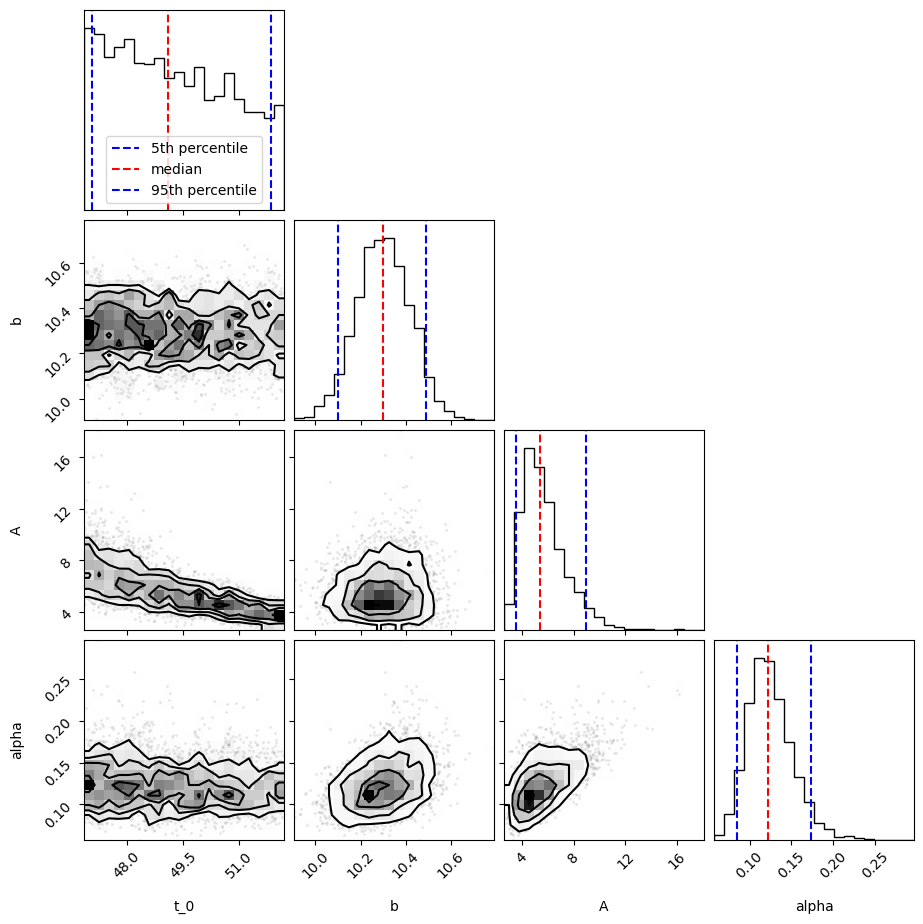

In [15]:
#Plot the corner distribution
fig = corner.corner(
    flat_samples, labels=labels
)

# Calculate percentiles for each parameter
percentiles = [5, 50, 95]
for i in range(flat_samples.shape[1]):
    vals = np.percentile(flat_samples[:, i], percentiles)
    ax = fig.axes[i * (flat_samples.shape[1] + 1)]  # 1D hist axes in corner
    for v, p in zip(vals, percentiles):
        ax.axvline(v, color='r' if p == 50 else 'b', linestyle='--', label=f'{p}th percentile' if p != 50 else 'median')
    # Optional: only add legend once
    if i == 0:
        ax.legend()

plt.show()

Text(0, 0.5, 'flux')

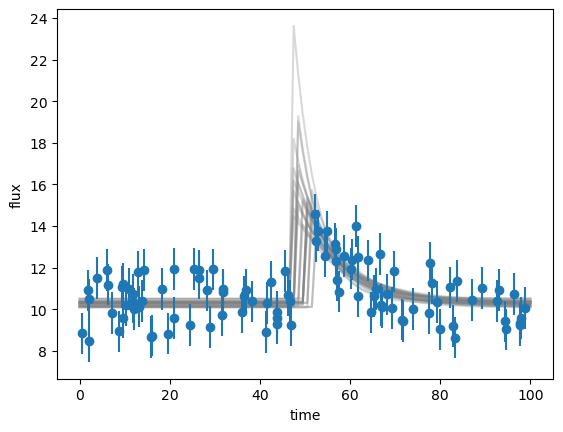

In [16]:
#Plot some samples of the model upon the data
chosen_samples= flat_samples[np.random.choice(len(flat_samples),size=30)]

tgrid=np.linspace(0,100,100)

for chosen_theta in chosen_samples:

    ygrid =  burst(chosen_theta,tgrid)
    plt.plot(tgrid,ygrid,alpha=0.3,c='gray')
    
plt.errorbar(data[:, 0], data[:, 1], data[:, 2], fmt = 'o')
plt.xlabel("time")
plt.ylabel("flux")

In [17]:
#Summary statistics
for i,l in enumerate(labels):
    low,med, up = np.percentile(flat_samples[:,i],[5,50,95]) 
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))

t_0   49.09342104277551 +2.7570066285013937 -2.0231255108270148
b   10.298862771674077 +0.1911340891221993 -0.19879679891467816
A   5.382236998207904 +3.5983861000500417 -1.8368477587017993
alpha   0.12154371034242512 +0.052258127227106405 -0.03590739722062619
